# Predicting Remaining Useful Life (RUL)

- Compiled codes from different repo's by Arockia Liborious

<div class="alert alert-block alert-info">
<b>Prevention is better than cure</b>, is a famous proverb and it applies almost everywhere.
</div>

Rather than repairing faults as they occur or scheduling equipment checks, it is preferable to foresee problems before they occur. `Machine learning algorithms` fine-tune the `Predictive Maintenance` method by analysing failure patterns and predicting potential issues using time-series data.

A machine learning algorithm collects and processes data from sensors that monitor parameters like moisture, temperature, and density. Machine learning models can predict equipment failure in a number of ways.

There are many machine learning development approaches depending on the prediction goal: remaining time until failure, failure probabilities, anomaly detection etc.

**Both classic machine learning and deep learning models can be used to predict the RUL. In this notebook both these techniques will be demonstrated. Hope you enjoy it**

## Classic Machine Learning

This use case will be approached in three sections

  - Understand the Data
  - Generate features
  - ML Modelling
  
The data set can found in this link [`Turbofan Engine Degradation Simulation Data Set from NASA`](https://ti.arc.nasa.gov/c/6/)

### Understanding the Data

In [9]:
import composeml as cp
import numpy as np
import pandas as pd
import featuretools as ft
import os
import utils

In [14]:
data_path = 'C:/Users/Arockia/AI Experiments/RUL Turbofan Data/train_FD004.txt'
data = utils.load_data(data_path)

data.head()

Loaded data with:
61249 Recordings
249 Engines
21 Sensor Measurements
3 Operational Settings


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,0,2000-01-01 00:00:00
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,1,2000-01-01 00:10:00
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,2,2000-01-01 00:20:00
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,3,2000-01-01 00:30:00
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,4,2000-01-01 00:40:00


There are 249 engines (engine no) in this dataset that are tracked over time (time in cycles). For each cycle, each engine's operational settings and sensor measurements were registered. The Remaining Useful Life (RUL) of an engine is the number of cycles it has left until it needs to be serviced. What makes this dataset unique is that the engines are run until they malfunction, giving us precise RUL data for each engine at any given time.

Real predictions can be simulated on by choosing a random point in the engine's life and only using data from before that point to train a model that will predict RUL. Features can be easily built using cutoff times in Featuretools. Compose, an open source project for automatically creating labels with cutoff times, will be used to organise the labelling process.

<br>

[Compose](https://compose.alteryx.com/) is a machine learning tool for automated prediction engineering. It allows you to structure prediction problems and generate labels for supervised learning. An end user defines an outcome of interest by writing a labeling function, then runs a search to automatically extract training examples from historical data. Its result is then provided to [Featuretools](https://docs.featuretools.com/) for automated feature engineering and subsequently to [EvalML](https://evalml.alteryx.com/) for automated machine learning. The workflow of an applied machine learning engineer then becomes:
<br>

<img src="https://warehouse-camo.ingress.cmh1.psfhosted.org/5c4ef41514dd37a3f5c5fba78eee081d91b2abcb/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f616c74657279782f636f6d706f73652f6d61696e2f646f63732f736f757263652f696d616765732f776f726b666c6f772e706e67" alt="Alt text that describes the graphic" title="Workflow of an applied machine learning" />

Read more about [Automated Feature Sunthesis](https://heartbeat.fritz.ai/introduction-to-automated-feature-engineering-using-deep-feature-synthesis-dfs-3feb69a7c00b)

In [15]:
# Defining Labeling Function

def remaining_useful_life(df):
    return len(df) - 1

In [16]:
# Creating Label Maker

lm = cp.LabelMaker(
    target_entity='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

In [17]:
# Searching labels
label_times = lm.search(
    data.sort_values('time'),
    num_examples_per_instance=1,
    minimum_data=100,
    verbose=True,
)

label_times.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| engine_no: 249/249 


,engine_no,time,remaining_useful_life
0,1,2000-01-01 16:40:00,220
1,2,2000-01-03 22:10:00,198
2,3,2000-01-06 00:00:00,206
3,4,2000-01-08 03:10:00,173
4,5,2000-01-10 00:50:00,92


Assume we want to make assumptions about turbines that are already operational. Since turbines rarely fail before 120 cycles, we will only build labels for engines that have completed at least 100 cycles. The minimum data parameter is set to 100 to achieve this. We can easily modify this parameter using Compose as our model's requirements shift. We restrict the search to one example per engine by setting_num_examples_per_instance to one.

In [18]:
label_times = lm.search(
    data.sort_values('time'),
    num_examples_per_instance=1,
    minimum_data=100,
    verbose=True,
)

label_times.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| engine_no: 249/249 


,engine_no,time,remaining_useful_life
0,1,2000-01-01 16:40:00,220
1,2,2000-01-03 22:10:00,198
2,3,2000-01-06 00:00:00,206
3,4,2000-01-08 03:10:00,173
4,5,2000-01-10 00:50:00,92


An entity is basically a table (dataframe). Each entity must have an index (uniquely identifying column). Entityset is a large data structure (dictionary) composed of many individual entities and the relationships between them.

We need to create an EntitySet structure for our data before we can use Deep Feature Synthesis. The key takeaway from this step is that we're really interested in the data that the engine collects. By normalising the raw data by the engine no column, we can create an engines entity. Rather than using the base dataframe of recordings, we'll create a feature matrix for the engines entity directly.

In [19]:
def make_entityset(data):
    es = ft.EntitySet('Dataset')

    es.entity_from_dataframe(
        dataframe=data,
        entity_id='recordings',
        index='index',
        time_index='time',
    )

    es.normalize_entity(
        base_entity_id='recordings',
        new_entity_id='engines',
        index='engine_no',
    )

    es.normalize_entity(
        base_entity_id='recordings',
        new_entity_id='cycles',
        index='time_in_cycles',
    )

    return es

In [20]:
es = make_entityset(data)
es

Entityset: Dataset
  Entities:
    recordings [Rows: 61249, Columns: 28]
    engines [Rows: 249, Columns: 2]
    cycles [Rows: 543, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.time_in_cycles -> cycles.time_in_cycles

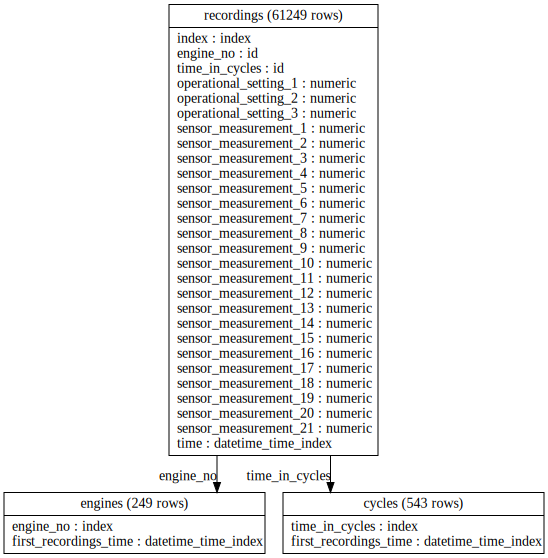

In [28]:
# viewing the entity set
es.plot()
# to get this plot install graphviz via and pip and backend both
# conda install python-graphviz
# pip install graphviz

### Feature Engineering using Deep Feature Synthesis

[Deep Feature Synthesis](https://docs.featuretools.com/en/v0.17.0/automated_feature_engineering/afe.html) (DFS) can be used to create features quickly. The function ft.dfs takes an EntitySet and stacks primitives like Max, Min and Last exhaustively across entities. [Medium Article](https://medium.com/@souvikmanna251/deep-feature-synthesis-introduction-to-feature-engineering-49438cdc143e). DFS is an automated method for performing feature engineering on relational and multi-table data. DFS works using the concept of stacking multiple primitives together to get deep features

We build features only using data up to and including the cutoff time of each label. This is done by setting the cutoff_time parameter to the label times we generated previously. Notice that the output of Compose integrates easily with Featuretools.

In [34]:

fm, features = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['last', 'max', 'min','std'],
    trans_primitives=[],
    cutoff_time=label_times,
    max_depth=3,
    verbose=True,
)

fm.to_csv('simple_fm.csv')

Built 484 features
Elapsed: 02:13 | Progress: 100%|██████████


### ML Modelling

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [36]:
fm = pd.read_csv('simple_fm.csv', index_col='engine_no')
X = fm.copy().fillna(0)
y = X.pop('remaining_useful_life')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

medianpredict1 = [np.median(y_train) for _ in y_test]
mae = mean_absolute_error(medianpredict1, y_test)
print('Baseline by median label: Mean Abs Error = {:.2f}'.format(mae))

Baseline by median label: Mean Abs Error = 59.98


In [37]:
from_train = es['recordings'].df['engine_no'].isin(y_train.index)
recordings_from_train = es['recordings'].df[from_train]
engines = recordings_from_train.groupby(['engine_no'])
median_life = np.median(engines.apply(lambda df: df.shape[0]))

from_test = es['recordings'].df['engine_no'].isin(y_test.index)
recordings_from_test = es['recordings'].df[from_test]
engines = recordings_from_test.groupby(['engine_no'])
life_in_test = engines.apply(lambda df: df.shape[0]) - y_test

medianpredict2 = median_life - life_in_test
medianpredict2 = medianpredict2.apply(lambda row: max(row, 0))
mae = mean_absolute_error(medianpredict2, y_test)
print('Baseline by median life: Mean Abs Error = {:.2f}'.format(mae))

Baseline by median life: Mean Abs Error = 59.98


In [38]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)
scores = mean_absolute_error(preds, y_test)
print('Mean Abs Error: {:.2f}'.format(scores))

high_imp_feats = utils.feature_importances(X, reg, feats=10)

Mean Abs Error: 53.09
1: MAX(recordings.cycles.LAST(recordings.sensor_measurement_4)) [0.060]
2: MIN(recordings.sensor_measurement_11) [0.054]
3: MIN(recordings.cycles.LAST(recordings.sensor_measurement_11)) [0.047]
4: MAX(recordings.sensor_measurement_4) [0.044]
5: MAX(recordings.sensor_measurement_13) [0.027]
6: MAX(recordings.cycles.LAST(recordings.sensor_measurement_11)) [0.026]
7: MAX(recordings.cycles.LAST(recordings.sensor_measurement_13)) [0.025]
8: MAX(recordings.sensor_measurement_15) [0.022]
9: MAX(recordings.sensor_measurement_11) [0.020]
10: MAX(recordings.cycles.LAST(recordings.sensor_measurement_15)) [0.018]
-----



In [40]:
data2 = utils.load_data('C:/Users/Arockia/AI Experiments/RUL Turbofan Data/test_FD004.txt')
es2 = make_entityset(data2)

fm2 = ft.calculate_feature_matrix(
    entityset=es2,
    features=features,
    verbose=True,
)

fm2.head()

Loaded data with:
41214 Recordings
248 Engines
21 Sensor Measurements
3 Operational Settings
Elapsed: 00:01 | Progress: 100%|██████████


,LAST(recordings.index),LAST(recordings.operational_setting_1),LAST(recordings.operational_setting_2),LAST(recordings.operational_setting_3),LAST(recordings.sensor_measurement_1),LAST(recordings.sensor_measurement_10),LAST(recordings.sensor_measurement_11),LAST(recordings.sensor_measurement_12),LAST(recordings.sensor_measurement_13),LAST(recordings.sensor_measurement_14),...,STD(recordings.cycles.STD(recordings.sensor_measurement_2)),STD(recordings.cycles.STD(recordings.sensor_measurement_20)),STD(recordings.cycles.STD(recordings.sensor_measurement_21)),STD(recordings.cycles.STD(recordings.sensor_measurement_3)),STD(recordings.cycles.STD(recordings.sensor_measurement_4)),STD(recordings.cycles.STD(recordings.sensor_measurement_5)),STD(recordings.cycles.STD(recordings.sensor_measurement_6)),STD(recordings.cycles.STD(recordings.sensor_measurement_7)),STD(recordings.cycles.STD(recordings.sensor_measurement_8)),STD(recordings.cycles.STD(recordings.sensor_measurement_9))
engine_no,,,,,,,,,,,,,,,,,,,,,
1,229,25.0070,0.6214,60.0,462.54,0.94,36.87,166.19,2028.53,7890.31,...,1.493438,0.517858,0.310844,4.547393,5.394094,0.195023,0.294292,7.857451,9.828001,14.470959
2,382,41.9989,0.8400,100.0,445.00,1.02,42.29,130.17,2387.72,8073.44,...,1.300455,0.432523,0.259824,4.110076,4.747221,0.161109,0.244166,6.580464,8.478189,12.956151
3,523,42.0005,0.8401,100.0,445.00,1.02,41.82,130.73,2388.18,8095.58,...,1.319041,0.438625,0.263309,4.169167,4.825935,0.162473,0.246817,6.677689,8.561284,13.117449
4,731,25.0018,0.6207,60.0,462.54,0.94,36.57,164.91,2028.30,7878.63,...,1.411439,0.479627,0.287727,4.503257,5.208275,0.180504,0.271983,7.283202,10.014734,14.378445
5,782,25.0039,0.6200,60.0,462.54,0.94,37.11,164.95,2028.24,7873.75,...,1.296952,0.427295,0.257009,3.859331,4.667388,0.159856,0.242664,6.526053,8.100689,12.090922


In [42]:
X = fm2.copy().fillna(0)

y = pd.read_csv(
    'C:/Users/Arockia/AI Experiments/RUL Turbofan Data/RUL_FD004.txt',
    sep=' ',
    header=None,
    names=['remaining_useful_life'],
    index_col=False,
)

preds2 = reg.predict(X)
mae = mean_absolute_error(preds2, y)
print('Mean Abs Error: {:.2f}'.format(mae))

medianpredict1 = [np.median(y_train) for _ in preds2]
mae = mean_absolute_error(medianpredict1, y)
print('Baseline by median label: Mean Abs Error = {:.2f}'.format(mae))

engines = es2['recordings'].df.groupby(['engine_no'])
medianpredict2 = median_life - engines.apply(lambda df: df.shape[0])
medianpredict2 = medianpredict2.apply(lambda row: max(row, 0))
mae = mean_absolute_error(medianpredict2, y)
print('Baseline by median life: Mean Abs Error = {:.2f}'.format(mae))

Mean Abs Error: 70.88
Baseline by median label: Mean Abs Error = 59.34
Baseline by median life: Mean Abs Error = 50.29


In [98]:
# Save output files
os.makedirs('output', exist_ok=True)
fm.to_csv('output/simple_train_feature_matrix.csv')
label_times.to_csv('output/simple_train_label_times.csv')
fm2.to_csv('output/simple_test_feature_matrix.csv')

[RUL Prediction Advanced Version](https://github.com/Featuretools/predict-remaining-useful-life/blob/master/Advanced%20Featuretools%20RUL.ipynb)

# RUL Prediction using CNN

**Research Papers:**

  - [Deep Convolutional Neural Network Based Regression Approach for Estimation of Remaining Useful Life](https://oar.a-star.edu.sg/jspui/bitstream/123456789/1681/3/DASFAA2016_014_final_v1.pdf)
  - [Ensemble of Data-Driven Prognostic Algorithms for Robust Prediction of Remaining Useful Life](https://0f7d60ce-a-62cb3a1a-s-sites.googlegroups.com/site/huchaostu/RESS-D-11-00126.pdf?attachauth=ANoY7cqrCyLpOku_pkxoWHddeJNWgB0u5QGUSVZ5nqV6mW2oOSSRmk29cjgVEYw03yXTjvx49R3PL9fiSei9YGdffW9tHgGWaPxPToj5EPP-KSAyxBebhwcl9YBJT8FX9bUT4QDnv4xhMQpafOPhbWcz-Sm7SoE5-eHLLEjW7CIpJvjbzRI15BqmHzULD7uMaB0BJyDzqwSlWZJuaZ-uiaAcaZ5JSkjCyg%3D%3D&attredirects=0)
  
**Dataset**
- [PHM08 Challenge Data](https://ti.arc.nasa.gov/c/13/)

In [53]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.preprocessing import scale

Instructions for updating:
non-resource variables are not supported in the long term


In [45]:
# helper functions
def windows(nrows, size):
    start,step = 0, 2
    while start < nrows:
        yield start, start + size
        start += step

def segment_signal(features,labels,window_size = 15):
    segments = np.empty((0,window_size))
    segment_labels = np.empty((0))
    nrows = len(features)
    for (start, end) in windows(nrows,window_size):
        if(len(data.iloc[start:end]) == window_size):
            segment = features[start:end].T  #Transpose to get segment of size 24 x 15 
            label = labels[(end-1)]
            segments = np.vstack([segments,segment]) 
            segment_labels = np.append(segment_labels,label)
    segments = segments.reshape(-1,24,window_size,1) # number of features  = 24 
    segment_labels = segment_labels.reshape(-1,1)
    return segments,segment_labels

In [46]:
data = pd.read_csv("C:/Users/Arockia/AI Experiments/PHM08.csv")
features = scale(data.iloc[:,2:26]) # select required columns and scale them
labels = data.iloc[:,26] # select RUL 

In [47]:
segments, labels = segment_signal(features,labels)

In [48]:
train_test_split = np.random.rand(len(segments)) < 0.70
train_x = segments[train_test_split]
train_y = labels[train_test_split]
test_x = segments[~train_test_split]
test_y = labels[~train_test_split]

In [49]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(1.0, shape = shape)
    return tf.Variable(initial)

def apply_conv(x,kernel_height,kernel_width,num_channels,depth):
    weights = weight_variable([kernel_height, kernel_width, num_channels, depth])
    biases = bias_variable([depth])
    return tf.nn.relu(tf.add(tf.nn.conv2d(x, weights,[1,1,1,1],padding="VALID"),biases))
    
def apply_max_pool(x,kernel_height,kernel_width,stride_size):
    return tf.nn.max_pool(x, ksize=[1, kernel_height, kernel_width, 1], strides=[1, 1, stride_size, 1], padding = "VALID")

In [50]:
num_labels = 1
batch_size = 10
num_hidden = 800
learning_rate = 0.0001
training_epochs = 30
input_height = 24
input_width = 15
num_channels = 1
total_batches = train_x.shape[0] // batch_size

In [54]:

X = tf.compat.v1.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.compat.v1.placeholder(tf.float32, shape=[None,num_labels])

c = apply_conv(X, kernel_height = 24, kernel_width = 4, num_channels = 1, depth = 8) 
p = apply_max_pool(c,kernel_height = 1, kernel_width = 2, stride_size = 2) 
c = apply_conv(p, kernel_height = 1, kernel_width = 3, num_channels = 8, depth = 14) 
p = apply_max_pool(c,kernel_height = 1, kernel_width = 2, stride_size = 2) 

shape = p.get_shape().as_list()
flat = tf.reshape(p, [-1, shape[1] * shape[2] * shape[3]])

f_weights = weight_variable([shape[1] * shape[2] * shape[3], num_hidden])
f_biases = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(flat, f_weights),f_biases))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.add(tf.matmul(f, out_weights),out_biases)

In [55]:
cost_function = tf.reduce_mean(tf.square(y_- Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)

In [56]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Training set MSE")
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_x.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size),:]
            _, c = session.run([optimizer, cost_function],feed_dict={X: batch_x, Y : batch_y})
            
        p_tr = session.run(y_, feed_dict={X:  train_x})
        tr_mse = tf.reduce_mean(tf.square(p_tr - train_y))
        print(session.run(tr_mse))

    p_ts = session.run(y_, feed_dict={X:  test_x})
    ts_mse = tf.reduce_mean(tf.square(p_ts - test_y))
    print("Test set MSE: %.4f" % session.run(ts_mse))

Training set MSE
4770.437483885454
4685.851054478055
4684.391755369346
4682.677435660879
4672.376961538895
4641.23070930066
4588.719417277493
4510.993474741395
4396.68805578844
4238.8188470953655
4052.2091148758113
3849.192618527206
3649.891486923957
3462.652150161221
3292.8828283951225
3144.4003032657893
3021.3369579478267
2923.3038656684494
2847.7429653393074
2788.0531464490014
2739.4254593744886
2696.279273380744
2658.6731644152665
2624.289105027751
2592.858792768443
2562.8596561587306
2531.830238843981
2502.904328162508
2478.2328774667303
2451.3858363605505
Test set MSE: 2515.2647


# RUL - LSTM

Please refer the [research paper](https://arxiv.org/pdf/1810.05644.pdf)

In [71]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(3321)

In [67]:
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.4.0
Numpy version:  1.19.3
Pandas version:  1.2.2
Scikit-learn version:  0.24.1


### Data Preprocessing

 - Explanation for data pre-processing steps done below can be found in this [notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb)

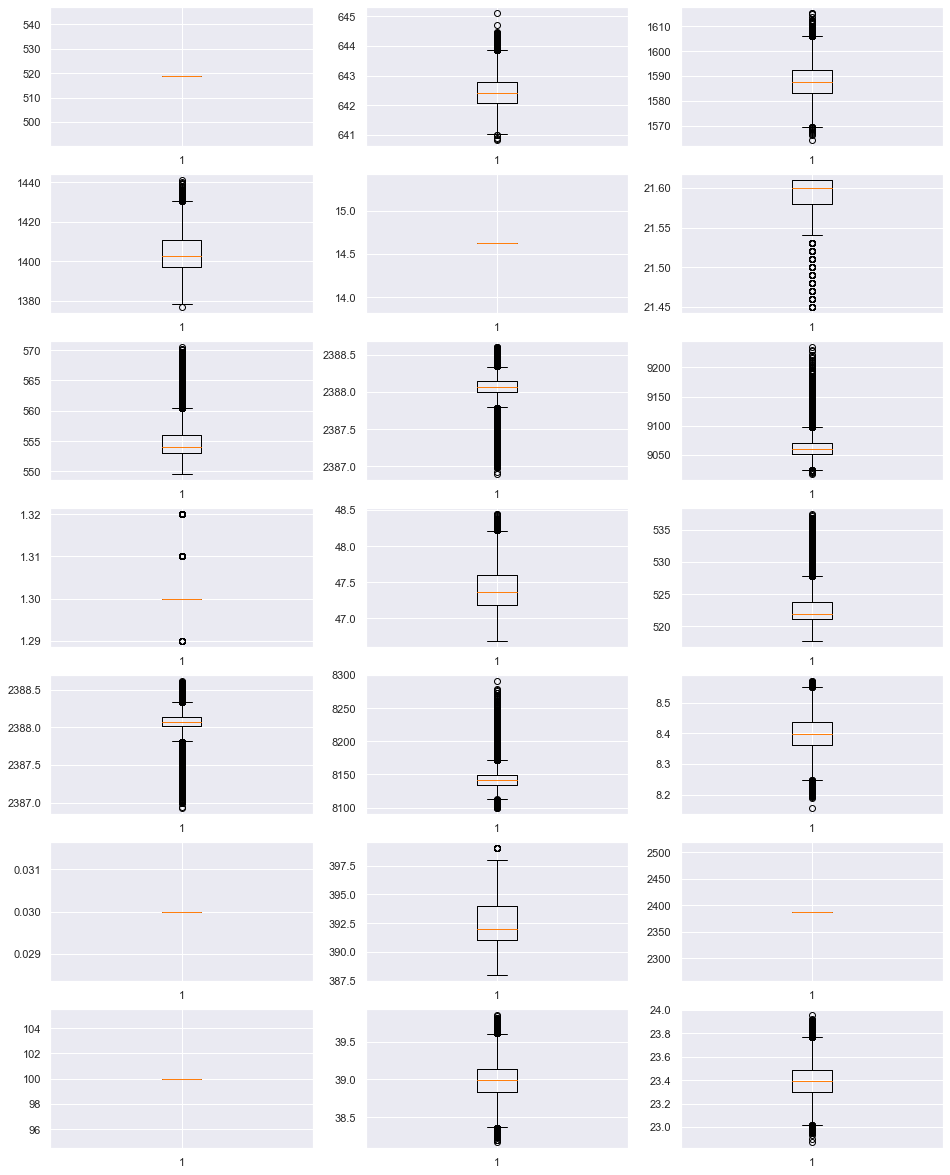

In [72]:
train_data = pd.read_csv("C:/Users/Arockia/AI Experiments/RUL Turbofan Data/train_FD003.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [73]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [74]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [75]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [76]:

test_data = pd.read_csv("C:/Users/Arockia/AI Experiments/RUL Turbofan Data/test_FD003.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("C:/Users/Arockia/AI Experiments/RUL Turbofan Data/RUL_FD003.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (21820, 30, 15)
Processed training ruls shape:  (21820,)
Processed test data shape:  (500, 30, 15)
True RUL shape:  (100,)


In [77]:
# Train test split

processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 48)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (17456, 30, 15)
Processed validation data shape:  (4364, 30, 15)
Processed train targets shape:  (17456,)
Processed validation targets shape:  (4364,)


In [96]:
# model
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (window_length, processed_train_data.shape[2]), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences=True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['mean_absolute_error'])
    return model

In [97]:
model1 = create_compiled_model()
history1 = model1.fit(processed_train_data, processed_train_targets, epochs = 50,
                    validation_data = (processed_val_data, processed_val_targets),
                    batch_size = 128, verbose = 2)

Train on 17456 samples, validate on 4364 samples
Epoch 1/50
17456/17456 - 13s - loss: 8917.8607 - mean_absolute_error: 85.2219 - val_loss: 7357.6091 - val_mean_absolute_error: 75.9241
Epoch 2/50
17456/17456 - 14s - loss: 5262.7953 - mean_absolute_error: 62.7097 - val_loss: 3170.0117 - val_mean_absolute_error: 47.7931
Epoch 3/50
17456/17456 - 15s - loss: 1791.4527 - mean_absolute_error: 35.4375 - val_loss: 832.5395 - val_mean_absolute_error: 24.9894
Epoch 4/50
17456/17456 - 16s - loss: 489.1218 - mean_absolute_error: 18.8845 - val_loss: 310.8354 - val_mean_absolute_error: 14.6299
Epoch 5/50
17456/17456 - 14s - loss: 237.0460 - mean_absolute_error: 12.2866 - val_loss: 201.0713 - val_mean_absolute_error: 10.7640
Epoch 6/50
17456/17456 - 14s - loss: 178.0878 - mean_absolute_error: 9.8062 - val_loss: 169.3355 - val_mean_absolute_error: 9.2854
Epoch 7/50
17456/17456 - 15s - loss: 150.4549 - mean_absolute_error: 8.5778 - val_loss: 159.4160 - val_mean_absolute_error: 8.7197
Epoch 8/50
17456/17

In [99]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    


    axes[1].plot(history.history['mean_absolute_error'])   
    axes[1].plot(history.history['val_mean_absolute_error'])
    axes[1].legend(['mean_absolute_error','val mean_absolute_error'])
    plt.ylabel('MAPE')
    plt.xlabel('Epoch')
    
    plt.show()

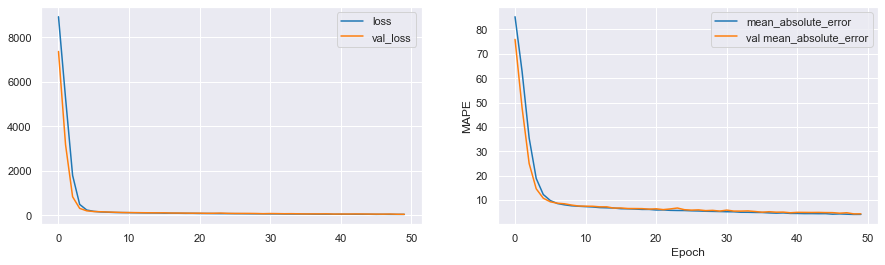

In [100]:
plot(history1)

In [101]:
rul_pred = model1.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  17.875688851445755


In [102]:
# save model

tf.keras.models.save_model(model1, "FD003_LSTM_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

In [103]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  16.55080781036462


In [104]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [105]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  697.8756569629473


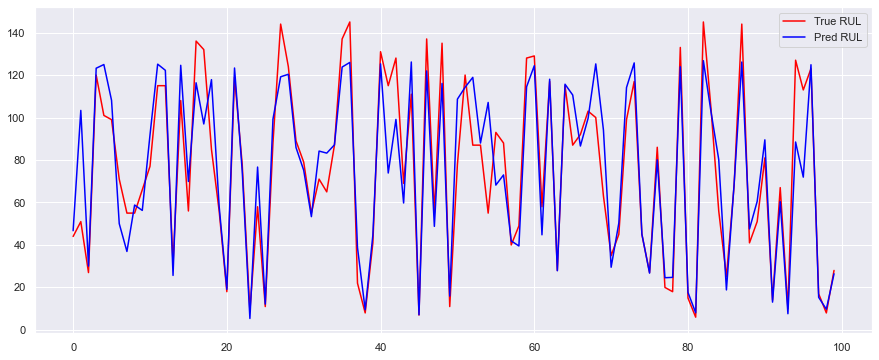

In [109]:
# Plot true and predicted RUL values
plt.figure(figsize=(15,6))
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

References:-
- [Link 1](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD003_LSTM_piecewise_linear_degradation_model.ipynb)
- [Link 2](https://github.com/Featuretools/predict-remaining-useful-life)
- [Link 3](https://github.com/aqibsaeed/Estimation-of-Remaining-Useful-Life-using-CNN)